In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_recall_curve, make_scorer
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Reading saved csv file
df_feat = pd.read_csv('data/DataTables/features.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_feat.columns = df_feat.iloc[0]
# Use first row info as header
df_feat.drop(df_feat.index[0], inplace=True)
# Drop first row
df_feat.drop(df_feat.columns[[0]], axis=1, inplace=True)
# removing the first column of NaNs that shows up from reading csv. Don't ask why. Sigh.

cols = df_feat.columns.drop('GVisitType')
df_feat[cols] = df_feat[cols].apply(pd.to_numeric, errors='coerce')
df_feat.dtypes

0
PtID              int64
GVisitType       object
Gender          float64
Weight          float64
Height          float64
ExStat            int64
BeforeEx          int64
AfterEx           int64
Episode           int64
MeanSensor      float64
MeanManual      float64
StdSensor       float64
StdManual       float64
MedianSensor    float64
MedianManual    float64
NumCalib          int64
MeanDiff        float64
StdDiff         float64
Peaks             int64
Valleys           int64
ExDiff            int64
BMI             float64
dtype: object

In [3]:
df = df_feat.dropna(axis=0, how='any')
# drop NaN values

patients = df['PtID'].as_matrix().astype(int)
visits = df['GVisitType'].as_matrix().astype(str)
np.savetxt('files/patients.dat', patients, fmt="%d")
np.savetxt('files/types.dat', visits, fmt="%s")

y = df['Episode']
y = y.as_matrix().astype(int)
indices = np.arange(len(y))
print(len(y[y==1]), len(y[y==0]))

df = df.drop(['PtID','GVisitType'], axis=1)
# since already saved these as separate arrays for identification
df = df.drop(['Gender', 'Height'], axis=1)
# since it gave 0 importance!!

df.drop(['Episode'],axis=1,inplace=True)
# 'Episode' is target only, so drop it from features!

45 56


In [4]:
x = df.as_matrix()

df.rename(index=str, columns={"ExStat": "Exercise Status", "BeforeEx": "Before Exercise", 
                             "AfterEx":"After Exercise", "MeanSensor": "Sensor Mean", "MeanManual": "Manual Mean", 
                             "StdSensor": "Sensor Stdev", "StdManual": "Manual Stdev", 
                             "MeanDiff": "Discrepancy Mean", "StdDiff": "Discrepancy Stdev", 
                             "MedianSensor": "Median Sensor", "MedianManual": "Median Manual", 
                              "NumCalib": "Calibrations", "ExDiff": "Drop from Exercise"}, inplace=True)
features = np.array(df.columns.astype(str))
np.savetxt('files/features.dat', features, fmt="%s")
print(features)
print(shape(x), shape(features))

['Weight' 'Exercise Status' 'Before Exercise' 'After Exercise'
 'Sensor Mean' 'Manual Mean' 'Sensor Stdev' 'Manual Stdev' 'Median Sensor'
 'Median Manual' 'Calibrations' 'Discrepancy Mean' 'Discrepancy Stdev'
 'Peaks' 'Valleys' 'Drop from Exercise' 'BMI']
(101, 17) (17,)


Text(0.5,19.5,'')

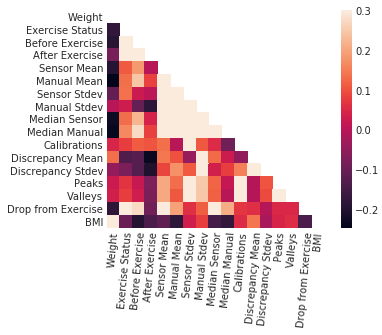

In [67]:
import seaborn as sns
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
plt.xticks(rotation=85)
plt.ylabel(''); plt.xlabel('') # remove weird hanging 0

In [5]:
from sklearn.model_selection import train_test_split

######################### Building Training and Testing Datasets ##############################
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x, y, indices, test_size=0.3, random_state=42, stratify=y)
# stored indices to reference specific patients and dates later

np.savetxt('files/x_train.dat', x_train) ; np.savetxt('files/y_train.dat', y_train)
np.savetxt('files/x_test.dat', x_test) ; np.savetxt('files/y_test.dat', y_test)
np.savetxt('files/ind_train.dat', ind_train) ; np.savetxt('files/ind_test.dat', ind_test)

print("train:",len(y_train[y_train==1]), len(y_train[y_train==0]))
print("test:",len(y_test[y_test==1]), len(y_test[y_test==0]))

train: 31 39
test: 14 17


In [6]:
# Basic Random Forest:
rf_basic = RandomForestClassifier(random_state=42)
print(rf_basic.get_params().keys())

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [44]:
param_grid = {'n_estimators': np.arange(10,501,40), 
              'min_samples_leaf':np.arange(2,10), 
              'warm_start':[True, False],
              'max_depth': np.arange(1,11,2),
              'max_features': np.arange(3,x_train.shape[1])}

rsearch = RandomizedSearchCV(estimator=rf_basic, param_distributions=param_grid, n_iter=100, cv=5, scoring='recall')
rsearch.fit(x_train, y_train)
print(rsearch)
# summarize the results of the random parameter search

print("#### best recall:", rsearch.best_score_)
print("#### best n_estimators:", rsearch.best_estimator_.n_estimators)
print("#### best min_sample_leaf:", rsearch.best_estimator_.min_samples_leaf)
print("#### best warm_start:", rsearch.best_estimator_.warm_start)
print("#### best max_depth", rsearch.best_estimator_.max_depth)
print("#### best max_features:", rsearch.best_estimator_.max_features)


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': array([ 10,  50,  90, 130, 170, 210, 250, 290, 330, 370, 410, 450, 490]), 'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]), 'warm_start': [True, False], 'max_depth': array([1, 3, 5, 7, 9]), 'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='recall', verbose=0)
#### best rec

In [45]:
############################# Pickling best model ###########################################
best= rsearch.best_params_
rf = RandomForestClassifier(max_depth=best['max_depth'], max_features=best['max_features'],
                            min_samples_leaf=best['min_samples_leaf'], n_estimators=best['n_estimators'],
                            warm_start=best['warm_start'], random_state=42)
rf.fit(x_train,y_train)
joblib.dump(rf,'test_models/model.pkl') 

['test_models/model.pkl']

In [51]:
rf = joblib.load('test_models/model.pkl')
lr = LogisticRegression(random_state=42)
dummy = DummyClassifier(strategy='uniform', random_state=42)

models = [dummy, lr, rf]
names = ["Chance", "Logistic Regression", "Random Forest"]

acc_mean = []; prec_mean = []; rec_mean = []
acc_std = []; prec_std = []; rec_std = []

for model, name in zip(models, names):
    print(name)
    accuracy = cross_val_score(model, x_train, y_train, cv=10)
    precision = cross_val_score(model, x_train, y_train, scoring='precision', cv=10)
    recall = cross_val_score(model, x_train, y_train, scoring='recall', cv=10)
                    
    acc_mean.append(accuracy.mean()); acc_std.append(accuracy.std())
    prec_mean.append(precision.mean()); prec_std.append(precision.std())
    rec_mean.append(recall.mean()); rec_std.append(recall.std())

print("accuracy:", acc_mean, acc_std)
print("precision:", prec_mean, prec_std)
print("recall:", rec_mean, rec_std)

Chance
Logistic Regression
Random Forest


/home/rashi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: [0.55714285714285716, 0.61488095238095231, 0.6785714285714286] [0.13093073414159542, 0.10747468456864273, 0.25]
precision: [0.5, 0.56666666666666665, 0.66166666666666674] [0.22360679774997896, 0.28087165910587863, 0.25863423336183994]
recall: [0.32500000000000001, 0.45833333333333331, 0.65000000000000002] [0.15115297622680879, 0.22745573439926967, 0.26299556396765839]


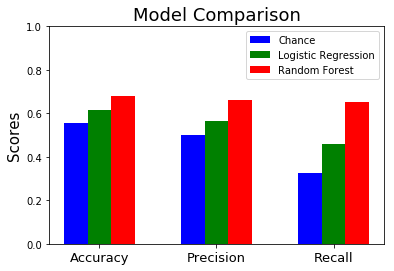

In [53]:
x = np.arange(1,4)

y = [acc_mean[0], prec_mean[0], rec_mean[0]] 
z = [acc_mean[1], prec_mean[1], rec_mean[1]]
k = [acc_mean[2], prec_mean[2], rec_mean[2]]

ax = plt.subplot(111)
ax.bar(x-0.2, y, width=0.2, color='b', align='center', label=names[0])
ax.bar(x, z, width=0.2, color='g', align='center', label=names[1])
ax.bar(x+0.2, k, width=0.2, color='r', align='center', label=names[2])

ax.set_ylim(0,1)
plt.xticks(x, ['Accuracy', 'Precision', 'Recall'], fontsize=13)
ax.set_ylabel('Scores', fontsize=15)
ax.set_title('Model Comparison', fontsize=18)
plt.legend()

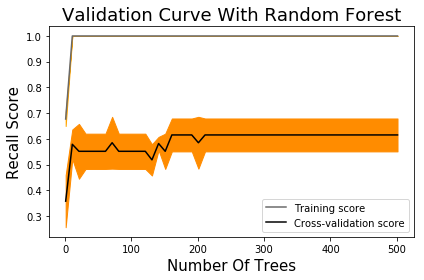

In [68]:
from sklearn.model_selection import validation_curve
# Create range of values for parameter
param_range = np.arange(1, 511, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(rf, x_train, y_train,
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="recall", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="dimgrey")
plt.plot(param_range, test_mean, label="Cross-validation score", color="black")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="darkorange")

# Create plot
plt.title("Validation Curve With Random Forest", fontsize=18)
plt.xlabel("Number Of Trees", fontsize=15)
plt.ylabel("Recall Score", fontsize=15)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

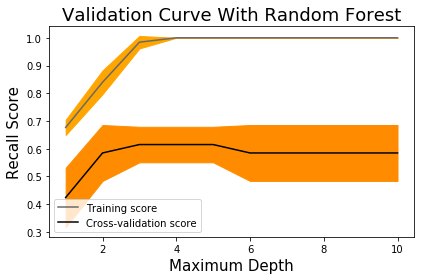

In [69]:
# Create range of values for parameter
param_range = np.arange(1,11)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(rf, x_train, y_train,
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="recall", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="dimgrey")
plt.plot(param_range, test_mean, label="Cross-validation score", color="black")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="darkorange")

# Create plot
plt.title("Validation Curve With Random Forest", fontsize=18)
plt.xlabel("Maximum Depth", fontsize=15)
plt.ylabel("Recall Score", fontsize=15)
plt.tight_layout()
plt.legend(loc="best")
plt.show()